In this notebook we load the saved ResNet152 trained model (using ResNet152_ModelTrain) and predict on the DFDC test dataset.

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install face_recognition library
!pip3 install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=b37d104ae403d7e3e8cc6dc18d684489cfbdcf39fe88d5f3344273f3775b91ed
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import models, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import face_recognition
import time
import sys

In [ ]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

sm = nn.Softmax()

def predict(model,img):
    """
  This function takes the video and converts it into logits and normalizes the
  logits using softmax() which then generates probabilties of the video being
  fake or real
  """
  fmap,logits = model(img.to('cuda'))
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',confidence)
  return [int(prediction.item()),confidence]

In [ ]:
class Model(nn.Module):
    """
  Base class for all neural network modules. Our models subclass this class.
  Use Model to load the saved trained model in the next step
  """
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnet152(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [ ]:
class validation_dataset(Dataset):
  """
  this class accepts preprocessed video dataset as input, extracts the faces from
  each of the video, recognizes the faces and stacks the extracted frames together
  """
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)      
        for i,frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

In [ ]:
# importing glob to return all file paths that match a specific pattern
import glob

# provide the path to the folder containing the preprocessed test files
video_files =  glob.glob('/content/drive/MyDrive/Deepfake/data/test/faces_test/*.mp4')
# printing the number of video files
print("Number of video files:",len(video_files))

# read the labels.csv into a df
labels = pd.read_csv('/content/drive/MyDrive/Deepfake/data/test/labels.csv')

No of video files: 4768


In [ ]:
# transform the images
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((im_size,im_size)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

video_dataset = validation_dataset(video_files,sequence_length = 10,transform = train_transforms)
# provide the path to the saved trained model
path_to_model = '/content/drive/MyDrive/Deepfake/data/checkpoints/resnet152_16k.pt'
# create an instance of Model class and load the trained model
model = Model(2).cuda()
model.load_state_dict(torch.load(path_to_model))
# sets the model in evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Model(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256,

In [ ]:
# predicting on the preprocessed test files
pred = []
conf = []
video_names = []
vcount = 0

for i in range(0,len(video_files)):
  print(video_files[i])
  prediction = predict(model,video_dataset[i])
  video_names.append(video_files)
  pred.append(prediction[0])
  conf.append(prediction[1])
  vcount = vcount + 1
  if prediction[0] == 1:
    print("REAL")
  else:
    print("FAKE")

  print("No of video processed", vcount)

/content/drive/MyDrive/Deepfake/data/test/faces_test/chsbgqykzl.mp4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Deepfake/data/test/faces_test/ydvcpnvczh.mp4
confidence of prediction: 99.34056997299194
FAKE
No of video processed 3519
/content/drive/MyDrive/Deepfake/data/test/faces_test/xqwcmnfnbm.mp4
confidence of prediction: 99.91361498832703
FAKE
No of video processed 3520
/content/drive/MyDrive/Deepfake/data/test/faces_test/lhndytetmf.mp4
confidence of prediction: 75.03747344017029
REAL
No of video processed 3521
/content/drive/MyDrive/Deepfake/data/test/faces_test/prtlvwzqcw.mp4
confidence of prediction: 99.93124008178711
REAL
No of video processed 3522
/content/drive/MyDrive/Deepfake/data/test/faces_test/xvvmrwsrql.mp4
confidence of prediction: 99.69660639762878
REAL
No of video processed 3523
/content/drive/MyDrive/Deepfake/data/test/faces_test/fiicezasqh.mp4
confidence of prediction: 56.46188259124756
FAKE
No of video processed 3524
/content/drive/MyDrive/Deepfake/data/test/faces_test/yohedlvirr.mp4
confidence of pre

In [ ]:
# converting the labels from 0 and 1 to fake and real, test videos labels are opposite to train video labels
for i in range(len(pred)):
  if pred[i] == 0:
    pred[i] = "Fake"
  elif pred[i] == 1:
    pred[i] = "Real"

In [ ]:
# extracting only the video names
vnames = []
for path in video_files:
  vnames.append(os.path.basename(path))

In [ ]:
# creating a list of actual labels of the videos
true_labels = []
for vf in vnames:
  if vf in list(labels['filename']):
    true_labels.append(*list(labels.loc[labels['filename'] == vf, 'label']))

In [ ]:
# converting the labels 0 and 1 to Real and Fake
for i in range(len(true_labels)):
  if true_labels[i] == 0:
    true_labels[i] = "Real"
  elif true_labels[i] == 1:
    true_labels[i] = "Fake"

In [ ]:
# create a dataframe from vnames, pred, conf, true_labels
predictionDF = pd.DataFrame(list(zip(vnames, pred, conf, true_labels)),
               columns =['Filename', 'Prediction', 'Confidence', 'TrueLabel'])

In [ ]:
predictionDF

,Filename,Prediction,Confidence,TrueLabel
0,chsbgqykzl.mp4,Fake,82.028472,Real
1,yppqnldpow.mp4,Real,81.023967,Fake
2,clltctfxgj.mp4,Fake,96.174234,Real
3,wuzzdfwxlv.mp4,Real,61.601329,Fake
4,ppzbhozhns.mp4,Real,99.589622,Real
...,...,...,...,...
4763,aqtrruhcat.mp4,Real,99.988866,Real
4764,nmffpjvask.mp4,Real,99.993432,Real
4765,vpbhgeavtr.mp4,Real,99.980229,Real
4766,nirpbnserk.mp4,Real,98.019433,Fake


In [ ]:
# printing the no of correctly classified files
correct_predictions = list(np.where(predictionDF['Prediction'] == predictionDF['TrueLabel'], True, False)).count(True)
print(f'{correct_predictions} correctly predicted files, out of {predictionDF.shape[0]} video files')

2781 correctly predicted files, out of 4768 video files


In [ ]:
# calculating the accuracy of the model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy of the model(in %):", accuracy_score(true_labels, pred)*100)

Accuracy of the model(in %): 58.32634228187919


In [ ]:
# printing the classification report
target_names = ['Fake', 'Real']
print(classification_report(true_labels, pred, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.66      0.35      0.46      2403
        Real       0.55      0.82      0.66      2365

    accuracy                           0.58      4768
   macro avg       0.61      0.59      0.56      4768
weighted avg       0.61      0.58      0.56      4768



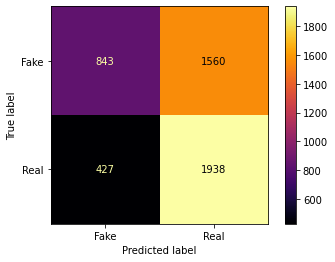

In [ ]:
# printing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score

ConfusionMatrixDisplay.from_predictions(true_labels, pred, cmap = 'inferno')
plt.show()

In [ ]:
# printing all the values of the confusion matrix
conf_mat = confusion_matrix(true_labels, pred)
print('True positive = ', conf_mat[0][0])
print('False positive = ', conf_mat[0][1])
print('False negative = ', conf_mat[1][0])
print('True negative = ', conf_mat[1][1])

True positive =  843
False positive =  1560
False negative =  427
True negative =  1938


In [ ]:
# function to convert labels into numbers 0 and 1
def convert_labels_to_num(pred_list):
  pred_list_num = []
  for i in range(len(pred_list)):
    if pred_list[i] == "Fake":
      pred_list_num.append(0)
    elif pred_list[i] == "Real":
      pred_list_num.append(1)

  return pred_list_num

In [ ]:
pred_num = convert_labels_to_num(pred)
truelabel_num = convert_labels_to_num(true_labels)

In [ ]:
# Display the roc_auc score of the model
roc_auc = roc_auc_score(truelabel_num, pred_num)
print(roc_auc)

0.585130901383841
